In [16]:
import numpy as np

class Node:
    def __init__(self, inputs = []):
        self.inputs = inputs
        self.outputs = []
        
        for n in self.inputs:
            n.outputs.append(self)
            
        self.value = None
        self.gradients = {}
        
        
    def forward(self):
        
        raise NotImplemented
    
    
    def backward(self):
        
        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        Node.__init__(self)
        
        
    def forward(self, value = None):
        
        if value is not None:
            self.value = value
     
    def backward(self):
        
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)
        
    
    def forward(self):
        self.value = sum(map(lambda n:n.value, self.inputs))
            
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])
       
    
    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
        
        self.value = np.dot(inputs, weights) + bias
        
        
    def backward(self):
        self.gradients = {n:np.zeros_like(n.value) for n in self.inputs}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis = 0, keepdims = False)
            
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1/(1 + np.exp(-1 * x))


    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)


    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))

        self.gradients = {n:np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = grad_cost * self.partial
                
class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])
        
        
    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)
        
        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a
        
        self.value = np.mean(self.diff**2)
        
        
    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff
        
        
def forward_and_backward(outputnode, graph):

    for n in graph:
        n.forward()

    for n in graph[::-1]:
        n.backward()
            

def topological_sort(feed_dict):

    input_nodes = [n for n in feed_dict.keys()]
    G = {}

    nodes = [n for n in input_nodes]

    while len(nodes) > 0:
        n = nodes.pop(0)
        
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
            
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)

    while len(S) > 0:
            n = S.pop()
            
            if isinstance(n, Input):
                n.value = feed_dict[n]
                
            L.append(n)
            for m in n.outputs:
                G[n]['out'].remove(m)
                G[m]['in'].remove(n)
                
                if len(G[m]['in']) == 0:
                    S.add(m)
    return L

    
    
def sgd_update(trainables, learning_rate = 1e-2):
    
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]
                

In [17]:
from sklearn.datasets import load_boston

In [18]:
data = load_boston()

In [19]:
losses = []

In [20]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample

data = load_boston()
X_ = data['data']
y_ = data['target']

X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_,
}

epochs = 5000
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        X_batch, y_batch = resample(X_, y_, n_samples = batch_size)
        
        X.value = X_batch
        y.value = y_batch
        
        _ = None
        forward_and_backward(_, graph)
        
        rate = 1e-2
        
        sgd_update(trainables, rate)
        
        loss += graph[-1].value
        
    if i % 100 == 0:
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 207.702
Epoch: 101, Loss: 8.066
Epoch: 201, Loss: 5.563
Epoch: 301, Loss: 4.926
Epoch: 401, Loss: 4.029
Epoch: 501, Loss: 4.179
Epoch: 601, Loss: 4.687
Epoch: 701, Loss: 4.262
Epoch: 801, Loss: 5.124
Epoch: 901, Loss: 4.059
Epoch: 1001, Loss: 3.827
Epoch: 1101, Loss: 4.058
Epoch: 1201, Loss: 3.958
Epoch: 1301, Loss: 3.522
Epoch: 1401, Loss: 3.498
Epoch: 1501, Loss: 3.858
Epoch: 1601, Loss: 3.510
Epoch: 1701, Loss: 3.837
Epoch: 1801, Loss: 3.306
Epoch: 1901, Loss: 3.872
Epoch: 2001, Loss: 3.937
Epoch: 2101, Loss: 3.840
Epoch: 2201, Loss: 3.134
Epoch: 2301, Loss: 3.356
Epoch: 2401, Loss: 3.816
Epoch: 2501, Loss: 3.345
Epoch: 2601, Loss: 3.311
Epoch: 2701, Loss: 3.242
Epoch: 2801, Loss: 3.313
Epoch: 2901, Loss: 4.317
Epoch: 3001, Loss: 3.954
Epoch: 3101, Loss: 3.463
Epoch: 3201, Loss: 3.653
Epoch: 3301, Loss: 3.641
Epoch: 3401, Loss: 3.264
Epoch: 3501, Loss: 3.249
Epoch: 3601, Loss: 3.495
Epoch: 3701, Loss: 3.426
Epoch: 3801, Loss: 3.642
Epoc

In [21]:
def forward(outputNode, graph):
    for n in graph:
        n.forward()
        
    return outputNode.value

In [22]:
forward(l2, graph)

array([[16.67496312],
       [26.78373774],
       [44.52856896],
       [18.03482761],
       [21.06617835],
       [12.08464477],
       [22.17059525],
       [19.66984694],
       [21.8297654 ],
       [ 6.38570492],
       [21.83111531],
       [ 9.97621264],
       [24.74605422],
       [19.61431561],
       [25.82569041],
       [26.51731615]])

In [23]:
import matplotlib.pyplot as plt

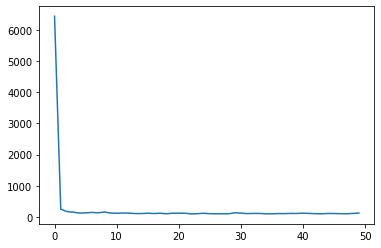

In [24]:
plt.plot(range(len(losses)), losses)

In [25]:
W2.value

array([[ 6.85821813],
       [11.15169121],
       [ 4.37674259],
       [ 8.60756706],
       [ 7.97912224],
       [ 6.73701128],
       [ 7.75031675],
       [ 3.75076597],
       [13.61120745],
       [ 7.58533659]])

In [26]:
X_ = data['data']

In [27]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [28]:
import keras

In [29]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units = 64, activation = 'sigmoid', input_dim = 13))
model.add(Dense(units = 30, activation = 'sigmoid', input_dim = 64))
model.add(Dense(units = 1))

model.compile(loss = 'mse',
              optimizer = 'sgd',
              metrics = ['mse'])

In [30]:
model.fit(X_, y_, epochs=5000, batch_size=32)

Epoch 1/5000
506/506 [==============================] - 0s 190us/step - loss: 153.4104 - mse: 153.4104
Epoch 2/5000
506/506 [==============================] - 0s 38us/step - loss: 81.2030 - mse: 81.2030
Epoch 3/5000
506/506 [==============================] - 0s 28us/step - loss: 80.4038 - mse: 80.4038
Epoch 4/5000
506/506 [==============================] - 0s 24us/step - loss: 77.0330 - mse: 77.0330
Epoch 5/5000
506/506 [==============================] - 0s 32us/step - loss: 79.3413 - mse: 79.3413
Epoch 6/5000
506/506 [==============================] - 0s 30us/step - loss: 79.3955 - mse: 79.3955
Epoch 7/5000
506/506 [==============================] - 0s 32us/step - loss: 77.7515 - mse: 77.7515
Epoch 8/5000
506/506 [==============================] - 0s 28us/step - loss: 78.3847 - mse: 78.3847
Epoch 9/5000
506/506 [==============================] - 0s 28us/step - loss: 81.8682 - mse: 81.8682
Epoch 10/5000
506/506 [==============================] - 0s 26us/step - loss: 88.4882 - mse: 88.4

506/506 [==============================] - 0s 28us/step - loss: 78.8771 - mse: 78.8771
Epoch 82/5000
506/506 [==============================] - 0s 28us/step - loss: 78.4439 - mse: 78.4439
Epoch 83/5000
506/506 [==============================] - 0s 30us/step - loss: 79.3504 - mse: 79.3504
Epoch 84/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3136 - mse: 77.3136
Epoch 85/5000
506/506 [==============================] - 0s 28us/step - loss: 79.1882 - mse: 79.1882
Epoch 86/5000
506/506 [==============================] - 0s 28us/step - loss: 77.9550 - mse: 77.9550
Epoch 87/5000
506/506 [==============================] - 0s 28us/step - loss: 78.2227 - mse: 78.2227
Epoch 88/5000
506/506 [==============================] - 0s 28us/step - loss: 78.4913 - mse: 78.4913
Epoch 89/5000
506/506 [==============================] - 0s 26us/step - loss: 77.7816 - mse: 77.7816
Epoch 90/5000
506/506 [==============================] - 0s 26us/step - loss: 78.3318 - mse: 78.3318
Epoc

506/506 [==============================] - 0s 30us/step - loss: 78.8254 - mse: 78.8254
Epoch 162/5000
506/506 [==============================] - 0s 28us/step - loss: 77.6694 - mse: 77.6694
Epoch 163/5000
506/506 [==============================] - 0s 28us/step - loss: 78.1177 - mse: 78.1177
Epoch 164/5000
506/506 [==============================] - 0s 26us/step - loss: 77.5117 - mse: 77.5117
Epoch 165/5000
506/506 [==============================] - 0s 28us/step - loss: 77.6150 - mse: 77.6151
Epoch 166/5000
506/506 [==============================] - 0s 38us/step - loss: 77.0024 - mse: 77.0024
Epoch 167/5000
506/506 [==============================] - 0s 24us/step - loss: 77.3480 - mse: 77.3480
Epoch 168/5000
506/506 [==============================] - 0s 26us/step - loss: 78.0226 - mse: 78.0226
Epoch 169/5000
506/506 [==============================] - 0s 24us/step - loss: 77.3387 - mse: 77.3387
Epoch 170/5000
506/506 [==============================] - 0s 24us/step - loss: 77.3582 - mse: 77.

506/506 [==============================] - 0s 32us/step - loss: 78.6376 - mse: 78.6376
Epoch 242/5000
506/506 [==============================] - 0s 32us/step - loss: 77.8251 - mse: 77.8251
Epoch 243/5000
506/506 [==============================] - 0s 32us/step - loss: 77.2317 - mse: 77.2317
Epoch 244/5000
506/506 [==============================] - 0s 32us/step - loss: 77.4958 - mse: 77.4958
Epoch 245/5000
506/506 [==============================] - 0s 36us/step - loss: 77.3508 - mse: 77.3508
Epoch 246/5000
506/506 [==============================] - 0s 38us/step - loss: 77.2418 - mse: 77.2418
Epoch 247/5000
506/506 [==============================] - 0s 30us/step - loss: 77.9804 - mse: 77.9804
Epoch 248/5000
506/506 [==============================] - 0s 30us/step - loss: 77.6424 - mse: 77.6424
Epoch 249/5000
506/506 [==============================] - 0s 30us/step - loss: 77.8818 - mse: 77.8818
Epoch 250/5000
506/506 [==============================] - 0s 34us/step - loss: 77.6392 - mse: 77.

506/506 [==============================] - 0s 26us/step - loss: 77.4444 - mse: 77.4444
Epoch 322/5000
506/506 [==============================] - 0s 32us/step - loss: 77.7653 - mse: 77.7653
Epoch 323/5000
506/506 [==============================] - 0s 28us/step - loss: 77.0892 - mse: 77.0892
Epoch 324/5000
506/506 [==============================] - 0s 41us/step - loss: 77.1937 - mse: 77.1937
Epoch 325/5000
506/506 [==============================] - 0s 36us/step - loss: 77.8003 - mse: 77.8003
Epoch 326/5000
506/506 [==============================] - 0s 34us/step - loss: 77.5022 - mse: 77.5022
Epoch 327/5000
506/506 [==============================] - 0s 28us/step - loss: 77.0704 - mse: 77.0704
Epoch 328/5000
506/506 [==============================] - 0s 28us/step - loss: 78.0700 - mse: 78.0700
Epoch 329/5000
506/506 [==============================] - 0s 32us/step - loss: 77.6799 - mse: 77.6799
Epoch 330/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2528 - mse: 77.

506/506 [==============================] - 0s 26us/step - loss: 77.5249 - mse: 77.5249
Epoch 402/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3854 - mse: 77.3854
Epoch 403/5000
506/506 [==============================] - 0s 30us/step - loss: 78.1657 - mse: 78.1657
Epoch 404/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4732 - mse: 77.4732
Epoch 405/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4483 - mse: 77.4483
Epoch 406/5000
506/506 [==============================] - 0s 24us/step - loss: 77.3196 - mse: 77.3196
Epoch 407/5000
506/506 [==============================] - 0s 26us/step - loss: 78.3811 - mse: 78.3811
Epoch 408/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4558 - mse: 77.4558
Epoch 409/5000
506/506 [==============================] - 0s 26us/step - loss: 77.5213 - mse: 77.5213
Epoch 410/5000
506/506 [==============================] - 0s 26us/step - loss: 77.7164 - mse: 77.

506/506 [==============================] - 0s 26us/step - loss: 77.2051 - mse: 77.2051
Epoch 482/5000
506/506 [==============================] - 0s 24us/step - loss: 77.7980 - mse: 77.7980
Epoch 483/5000
506/506 [==============================] - 0s 28us/step - loss: 77.5020 - mse: 77.5020
Epoch 484/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2844 - mse: 77.2844
Epoch 485/5000
506/506 [==============================] - 0s 28us/step - loss: 77.7457 - mse: 77.7457
Epoch 486/5000
506/506 [==============================] - 0s 24us/step - loss: 77.4339 - mse: 77.4339
Epoch 487/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3199 - mse: 77.3199
Epoch 488/5000
506/506 [==============================] - 0s 28us/step - loss: 77.7951 - mse: 77.7951
Epoch 489/5000
506/506 [==============================] - 0s 26us/step - loss: 77.5952 - mse: 77.5952
Epoch 490/5000
506/506 [==============================] - 0s 24us/step - loss: 76.5857 - mse: 76.

506/506 [==============================] - 0s 36us/step - loss: 77.8829 - mse: 77.8829
Epoch 562/5000
506/506 [==============================] - 0s 40us/step - loss: 78.3737 - mse: 78.3737
Epoch 563/5000
506/506 [==============================] - 0s 40us/step - loss: 77.5830 - mse: 77.5830
Epoch 564/5000
506/506 [==============================] - 0s 36us/step - loss: 78.2956 - mse: 78.2956
Epoch 565/5000
506/506 [==============================] - 0s 34us/step - loss: 77.5711 - mse: 77.5711
Epoch 566/5000
506/506 [==============================] - 0s 36us/step - loss: 77.7072 - mse: 77.7072
Epoch 567/5000
506/506 [==============================] - 0s 38us/step - loss: 77.1463 - mse: 77.1463
Epoch 568/5000
506/506 [==============================] - 0s 38us/step - loss: 77.7033 - mse: 77.7033
Epoch 569/5000
506/506 [==============================] - 0s 40us/step - loss: 77.6987 - mse: 77.6987
Epoch 570/5000
506/506 [==============================] - 0s 41us/step - loss: 77.5040 - mse: 77.

506/506 [==============================] - 0s 28us/step - loss: 77.6625 - mse: 77.6625
Epoch 642/5000
506/506 [==============================] - 0s 47us/step - loss: 77.5322 - mse: 77.5322
Epoch 643/5000
506/506 [==============================] - 0s 45us/step - loss: 77.6086 - mse: 77.6086
Epoch 644/5000
506/506 [==============================] - 0s 41us/step - loss: 77.9051 - mse: 77.9051
Epoch 645/5000
506/506 [==============================] - 0s 30us/step - loss: 77.8553 - mse: 77.8553
Epoch 646/5000
506/506 [==============================] - 0s 32us/step - loss: 77.5600 - mse: 77.5600
Epoch 647/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4563 - mse: 77.4563
Epoch 648/5000
506/506 [==============================] - 0s 26us/step - loss: 77.1198 - mse: 77.1198
Epoch 649/5000
506/506 [==============================] - 0s 45us/step - loss: 77.2604 - mse: 77.2604
Epoch 650/5000
506/506 [==============================] - 0s 40us/step - loss: 77.2128 - mse: 77.

506/506 [==============================] - 0s 32us/step - loss: 77.5821 - mse: 77.5821
Epoch 722/5000
506/506 [==============================] - 0s 32us/step - loss: 77.0464 - mse: 77.0464
Epoch 723/5000
506/506 [==============================] - 0s 39us/step - loss: 77.2500 - mse: 77.2500
Epoch 724/5000
506/506 [==============================] - 0s 38us/step - loss: 77.6338 - mse: 77.6339
Epoch 725/5000
506/506 [==============================] - 0s 30us/step - loss: 77.7299 - mse: 77.7299
Epoch 726/5000
506/506 [==============================] - 0s 30us/step - loss: 77.7399 - mse: 77.7399
Epoch 727/5000
506/506 [==============================] - 0s 28us/step - loss: 77.8863 - mse: 77.8863
Epoch 728/5000
506/506 [==============================] - 0s 24us/step - loss: 77.1810 - mse: 77.1810
Epoch 729/5000
506/506 [==============================] - 0s 26us/step - loss: 77.6959 - mse: 77.6959
Epoch 730/5000
506/506 [==============================] - 0s 26us/step - loss: 77.5734 - mse: 77.

506/506 [==============================] - 0s 32us/step - loss: 78.0506 - mse: 78.0506
Epoch 802/5000
506/506 [==============================] - 0s 34us/step - loss: 76.7642 - mse: 76.7642
Epoch 803/5000
506/506 [==============================] - 0s 38us/step - loss: 77.4119 - mse: 77.4119
Epoch 804/5000
506/506 [==============================] - 0s 36us/step - loss: 77.2932 - mse: 77.2932
Epoch 805/5000
506/506 [==============================] - 0s 32us/step - loss: 77.4967 - mse: 77.4967
Epoch 806/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1590 - mse: 77.1590
Epoch 807/5000
506/506 [==============================] - 0s 30us/step - loss: 76.7837 - mse: 76.7837
Epoch 808/5000
506/506 [==============================] - 0s 32us/step - loss: 77.7989 - mse: 77.7989
Epoch 809/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1443 - mse: 77.1443
Epoch 810/5000
506/506 [==============================] - 0s 40us/step - loss: 77.4663 - mse: 77.

506/506 [==============================] - 0s 32us/step - loss: 77.2832 - mse: 77.2832
Epoch 882/5000
506/506 [==============================] - 0s 30us/step - loss: 77.5080 - mse: 77.5080
Epoch 883/5000
506/506 [==============================] - 0s 30us/step - loss: 77.0281 - mse: 77.0281
Epoch 884/5000
506/506 [==============================] - 0s 24us/step - loss: 77.3789 - mse: 77.3789
Epoch 885/5000
506/506 [==============================] - 0s 28us/step - loss: 76.8874 - mse: 76.8874
Epoch 886/5000
506/506 [==============================] - 0s 26us/step - loss: 77.7587 - mse: 77.7587
Epoch 887/5000
506/506 [==============================] - 0s 32us/step - loss: 77.5479 - mse: 77.5479
Epoch 888/5000
506/506 [==============================] - 0s 26us/step - loss: 77.7056 - mse: 77.7056
Epoch 889/5000
506/506 [==============================] - 0s 26us/step - loss: 77.9317 - mse: 77.9317
Epoch 890/5000
506/506 [==============================] - 0s 28us/step - loss: 77.6921 - mse: 77.

506/506 [==============================] - 0s 30us/step - loss: 77.1848 - mse: 77.1848
Epoch 962/5000
506/506 [==============================] - 0s 28us/step - loss: 77.5156 - mse: 77.5156
Epoch 963/5000
506/506 [==============================] - 0s 28us/step - loss: 77.5582 - mse: 77.5582
Epoch 964/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1441 - mse: 77.1441
Epoch 965/5000
506/506 [==============================] - 0s 28us/step - loss: 77.6248 - mse: 77.6248
Epoch 966/5000
506/506 [==============================] - 0s 26us/step - loss: 77.5460 - mse: 77.5461
Epoch 967/5000
506/506 [==============================] - 0s 29us/step - loss: 77.3720 - mse: 77.3720
Epoch 968/5000
506/506 [==============================] - 0s 26us/step - loss: 77.7418 - mse: 77.7418
Epoch 969/5000
506/506 [==============================] - 0s 28us/step - loss: 77.4118 - mse: 77.4118
Epoch 970/5000
506/506 [==============================] - 0s 28us/step - loss: 78.0639 - mse: 78.

506/506 [==============================] - 0s 30us/step - loss: 77.9617 - mse: 77.9617
Epoch 1042/5000
506/506 [==============================] - 0s 28us/step - loss: 76.9688 - mse: 76.9688
Epoch 1043/5000
506/506 [==============================] - 0s 30us/step - loss: 77.6395 - mse: 77.6395
Epoch 1044/5000
506/506 [==============================] - 0s 29us/step - loss: 77.4845 - mse: 77.4845
Epoch 1045/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2117 - mse: 77.2117
Epoch 1046/5000
506/506 [==============================] - 0s 30us/step - loss: 77.6763 - mse: 77.6763
Epoch 1047/5000
506/506 [==============================] - 0s 30us/step - loss: 77.4839 - mse: 77.4839
Epoch 1048/5000
506/506 [==============================] - 0s 30us/step - loss: 77.6281 - mse: 77.6281
Epoch 1049/5000
506/506 [==============================] - 0s 28us/step - loss: 77.8614 - mse: 77.8614
Epoch 1050/5000
506/506 [==============================] - 0s 30us/step - loss: 77.3485 -

506/506 [==============================] - 0s 24us/step - loss: 77.3010 - mse: 77.3010
Epoch 1121/5000
506/506 [==============================] - 0s 26us/step - loss: 77.0637 - mse: 77.0637
Epoch 1122/5000
506/506 [==============================] - 0s 26us/step - loss: 77.7114 - mse: 77.7114
Epoch 1123/5000
506/506 [==============================] - ETA: 0s - loss: 61.5443 - mse: 61.544 - 0s 24us/step - loss: 77.2610 - mse: 77.2610
Epoch 1124/5000
506/506 [==============================] - 0s 24us/step - loss: 77.2753 - mse: 77.2753
Epoch 1125/5000
506/506 [==============================] - 0s 24us/step - loss: 77.5358 - mse: 77.5358
Epoch 1126/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3706 - mse: 77.3706
Epoch 1127/5000
506/506 [==============================] - 0s 34us/step - loss: 77.3575 - mse: 77.3575
Epoch 1128/5000
506/506 [==============================] - 0s 32us/step - loss: 77.3837 - mse: 77.3837
Epoch 1129/5000
506/506 [========================

506/506 [==============================] - 0s 34us/step - loss: 77.2378 - mse: 77.2378
Epoch 1200/5000
506/506 [==============================] - 0s 34us/step - loss: 77.2142 - mse: 77.2142
Epoch 1201/5000
506/506 [==============================] - 0s 30us/step - loss: 77.4830 - mse: 77.4830
Epoch 1202/5000
506/506 [==============================] - 0s 28us/step - loss: 77.8912 - mse: 77.8912
Epoch 1203/5000
506/506 [==============================] - 0s 30us/step - loss: 77.4135 - mse: 77.4135
Epoch 1204/5000
506/506 [==============================] - 0s 30us/step - loss: 77.5281 - mse: 77.5282
Epoch 1205/5000
506/506 [==============================] - 0s 34us/step - loss: 77.4356 - mse: 77.4356
Epoch 1206/5000
506/506 [==============================] - 0s 26us/step - loss: 77.5511 - mse: 77.5511
Epoch 1207/5000
506/506 [==============================] - 0s 26us/step - loss: 77.1471 - mse: 77.1471
Epoch 1208/5000
506/506 [==============================] - 0s 28us/step - loss: 77.0603 -

506/506 [==============================] - 0s 26us/step - loss: 77.3104 - mse: 77.3104
Epoch 1279/5000
506/506 [==============================] - 0s 28us/step - loss: 77.5724 - mse: 77.5724
Epoch 1280/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2612 - mse: 77.2612
Epoch 1281/5000
506/506 [==============================] - 0s 26us/step - loss: 76.9716 - mse: 76.9716
Epoch 1282/5000
506/506 [==============================] - 0s 26us/step - loss: 76.8587 - mse: 76.8587
Epoch 1283/5000
506/506 [==============================] - 0s 24us/step - loss: 77.1816 - mse: 77.1816
Epoch 1284/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3436 - mse: 77.3436
Epoch 1285/5000
506/506 [==============================] - 0s 26us/step - loss: 77.6571 - mse: 77.6571
Epoch 1286/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3052 - mse: 77.3052
Epoch 1287/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2567 -

506/506 [==============================] - 0s 32us/step - loss: 77.5852 - mse: 77.5852
Epoch 1358/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3613 - mse: 77.3613
Epoch 1359/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3584 - mse: 77.3584
Epoch 1360/5000
506/506 [==============================] - 0s 32us/step - loss: 77.0995 - mse: 77.0995
Epoch 1361/5000
506/506 [==============================] - 0s 30us/step - loss: 77.3598 - mse: 77.3598
Epoch 1362/5000
506/506 [==============================] - 0s 30us/step - loss: 77.4036 - mse: 77.4036
Epoch 1363/5000
506/506 [==============================] - 0s 26us/step - loss: 78.3243 - mse: 78.3243
Epoch 1364/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2440 - mse: 77.2440
Epoch 1365/5000
506/506 [==============================] - 0s 30us/step - loss: 77.0990 - mse: 77.0990
Epoch 1366/5000
506/506 [==============================] - 0s 30us/step - loss: 77.5520 -

506/506 [==============================] - 0s 28us/step - loss: 77.3986 - mse: 77.3986
Epoch 1437/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4219 - mse: 77.4219
Epoch 1438/5000
506/506 [==============================] - 0s 26us/step - loss: 77.5291 - mse: 77.5291
Epoch 1439/5000
506/506 [==============================] - 0s 28us/step - loss: 77.6303 - mse: 77.6303
Epoch 1440/5000
506/506 [==============================] - 0s 28us/step - loss: 77.5832 - mse: 77.5832
Epoch 1441/5000
506/506 [==============================] - 0s 25us/step - loss: 77.3947 - mse: 77.3947
Epoch 1442/5000
506/506 [==============================] - 0s 30us/step - loss: 77.3169 - mse: 77.3168
Epoch 1443/5000
506/506 [==============================] - 0s 28us/step - loss: 77.5389 - mse: 77.5389
Epoch 1444/5000
506/506 [==============================] - 0s 26us/step - loss: 76.8448 - mse: 76.8448
Epoch 1445/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2486 -

506/506 [==============================] - 0s 28us/step - loss: 77.3007 - mse: 77.3007
Epoch 1516/5000
506/506 [==============================] - 0s 28us/step - loss: 77.4014 - mse: 77.4014
Epoch 1517/5000
506/506 [==============================] - 0s 30us/step - loss: 77.3601 - mse: 77.3601
Epoch 1518/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1531 - mse: 77.1531
Epoch 1519/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1658 - mse: 77.1658
Epoch 1520/5000
506/506 [==============================] - 0s 30us/step - loss: 77.1882 - mse: 77.1882
Epoch 1521/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3873 - mse: 77.3873
Epoch 1522/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2806 - mse: 77.2806
Epoch 1523/5000
506/506 [==============================] - 0s 30us/step - loss: 77.3513 - mse: 77.3513
Epoch 1524/5000
506/506 [==============================] - 0s 30us/step - loss: 77.7531 -

506/506 [==============================] - 0s 32us/step - loss: 77.4176 - mse: 77.4176
Epoch 1595/5000
506/506 [==============================] - 0s 28us/step - loss: 77.4974 - mse: 77.4974
Epoch 1596/5000
506/506 [==============================] - 0s 34us/step - loss: 77.1093 - mse: 77.1093
Epoch 1597/5000
506/506 [==============================] - 0s 30us/step - loss: 77.6794 - mse: 77.6794
Epoch 1598/5000
506/506 [==============================] - 0s 28us/step - loss: 76.5504 - mse: 76.5504
Epoch 1599/5000
506/506 [==============================] - 0s 30us/step - loss: 77.8679 - mse: 77.8679
Epoch 1600/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3870 - mse: 77.3870
Epoch 1601/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3236 - mse: 77.3236
Epoch 1602/5000
506/506 [==============================] - 0s 28us/step - loss: 77.4598 - mse: 77.4598
Epoch 1603/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2214 -

506/506 [==============================] - 0s 24us/step - loss: 77.5182 - mse: 77.5182
Epoch 1674/5000
506/506 [==============================] - 0s 30us/step - loss: 77.9744 - mse: 77.9744
Epoch 1675/5000
506/506 [==============================] - 0s 34us/step - loss: 77.2428 - mse: 77.2428
Epoch 1676/5000
506/506 [==============================] - 0s 30us/step - loss: 77.3971 - mse: 77.3971
Epoch 1677/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2896 - mse: 77.2896
Epoch 1678/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3288 - mse: 77.3288
Epoch 1679/5000
506/506 [==============================] - 0s 28us/step - loss: 77.4298 - mse: 77.4298
Epoch 1680/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3834 - mse: 77.3834
Epoch 1681/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3858 - mse: 77.3858
Epoch 1682/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2965 -

506/506 [==============================] - 0s 26us/step - loss: 78.0048 - mse: 78.0048
Epoch 1753/5000
506/506 [==============================] - 0s 26us/step - loss: 77.5495 - mse: 77.5495
Epoch 1754/5000
506/506 [==============================] - 0s 30us/step - loss: 77.4535 - mse: 77.4535
Epoch 1755/5000
506/506 [==============================] - 0s 26us/step - loss: 77.6693 - mse: 77.6693
Epoch 1756/5000
506/506 [==============================] - 0s 28us/step - loss: 77.4892 - mse: 77.4892
Epoch 1757/5000
506/506 [==============================] - 0s 28us/step - loss: 77.4864 - mse: 77.4865
Epoch 1758/5000
506/506 [==============================] - 0s 24us/step - loss: 77.1063 - mse: 77.1063
Epoch 1759/5000
506/506 [==============================] - 0s 24us/step - loss: 77.4914 - mse: 77.4914
Epoch 1760/5000
506/506 [==============================] - 0s 30us/step - loss: 77.8801 - mse: 77.8801
Epoch 1761/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2041 -

506/506 [==============================] - 0s 24us/step - loss: 77.5134 - mse: 77.5134
Epoch 1832/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2745 - mse: 77.2746
Epoch 1833/5000
506/506 [==============================] - 0s 26us/step - loss: 77.7563 - mse: 77.7563
Epoch 1834/5000
506/506 [==============================] - 0s 32us/step - loss: 77.5982 - mse: 77.5982
Epoch 1835/5000
506/506 [==============================] - 0s 34us/step - loss: 77.2282 - mse: 77.2282
Epoch 1836/5000
506/506 [==============================] - 0s 34us/step - loss: 77.6492 - mse: 77.6492
Epoch 1837/5000
506/506 [==============================] - 0s 26us/step - loss: 77.1351 - mse: 77.1351
Epoch 1838/5000
506/506 [==============================] - 0s 30us/step - loss: 77.0930 - mse: 77.0930
Epoch 1839/5000
506/506 [==============================] - 0s 24us/step - loss: 77.0494 - mse: 77.0494
Epoch 1840/5000
506/506 [==============================] - 0s 28us/step - loss: 77.0667 -

506/506 [==============================] - 0s 30us/step - loss: 77.2671 - mse: 77.2671
Epoch 1911/5000
506/506 [==============================] - 0s 31us/step - loss: 77.2651 - mse: 77.2651
Epoch 1912/5000
506/506 [==============================] - 0s 32us/step - loss: 77.6030 - mse: 77.6030
Epoch 1913/5000
506/506 [==============================] - 0s 30us/step - loss: 77.7000 - mse: 77.7000
Epoch 1914/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3887 - mse: 77.3887
Epoch 1915/5000
506/506 [==============================] - 0s 34us/step - loss: 77.6416 - mse: 77.6416
Epoch 1916/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2562 - mse: 77.2562
Epoch 1917/5000
506/506 [==============================] - 0s 32us/step - loss: 77.4307 - mse: 77.4307
Epoch 1918/5000
506/506 [==============================] - 0s 30us/step - loss: 77.5437 - mse: 77.5437
Epoch 1919/5000
506/506 [==============================] - 0s 30us/step - loss: 77.5402 -

506/506 [==============================] - 0s 26us/step - loss: 77.1803 - mse: 77.1803
Epoch 1990/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2145 - mse: 77.2145
Epoch 1991/5000
506/506 [==============================] - 0s 28us/step - loss: 77.6627 - mse: 77.6628
Epoch 1992/5000
506/506 [==============================] - 0s 28us/step - loss: 77.4139 - mse: 77.4139
Epoch 1993/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3435 - mse: 77.3436
Epoch 1994/5000
506/506 [==============================] - 0s 32us/step - loss: 77.6428 - mse: 77.6428
Epoch 1995/5000
506/506 [==============================] - 0s 26us/step - loss: 77.0936 - mse: 77.0936
Epoch 1996/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2643 - mse: 77.2643
Epoch 1997/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2475 - mse: 77.2475
Epoch 1998/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1509 -

506/506 [==============================] - 0s 28us/step - loss: 77.4507 - mse: 77.4507
Epoch 2068/5000
506/506 [==============================] - 0s 26us/step - loss: 77.0665 - mse: 77.0665
Epoch 2069/5000
506/506 [==============================] - 0s 26us/step - loss: 77.0936 - mse: 77.0936
Epoch 2070/5000
506/506 [==============================] - 0s 30us/step - loss: 77.1602 - mse: 77.1602
Epoch 2071/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3526 - mse: 77.3526
Epoch 2072/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1867 - mse: 77.1867
Epoch 2073/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1082 - mse: 77.1082
Epoch 2074/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4234 - mse: 77.4234
Epoch 2075/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2005 - mse: 77.2005
Epoch 2076/5000
506/506 [==============================] - 0s 30us/step - loss: 77.4457 -

506/506 [==============================] - 0s 28us/step - loss: 77.2504 - mse: 77.2504
Epoch 2147/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2731 - mse: 77.2731
Epoch 2148/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3576 - mse: 77.3576
Epoch 2149/5000
506/506 [==============================] - 0s 26us/step - loss: 77.1329 - mse: 77.1329
Epoch 2150/5000
506/506 [==============================] - 0s 26us/step - loss: 77.6212 - mse: 77.6212
Epoch 2151/5000
506/506 [==============================] - 0s 28us/step - loss: 77.8191 - mse: 77.8191
Epoch 2152/5000
506/506 [==============================] - 0s 28us/step - loss: 76.8712 - mse: 76.8712
Epoch 2153/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3707 - mse: 77.3707
Epoch 2154/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2993 - mse: 77.2993
Epoch 2155/5000
506/506 [==============================] - 0s 26us/step - loss: 77.0146 -

506/506 [==============================] - 0s 28us/step - loss: 77.2599 - mse: 77.2599
Epoch 2226/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4104 - mse: 77.4104
Epoch 2227/5000
506/506 [==============================] - 0s 30us/step - loss: 77.7572 - mse: 77.7572
Epoch 2228/5000
506/506 [==============================] - 0s 26us/step - loss: 77.1297 - mse: 77.1297
Epoch 2229/5000
506/506 [==============================] - 0s 30us/step - loss: 77.5010 - mse: 77.5010
Epoch 2230/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1675 - mse: 77.1675
Epoch 2231/5000
506/506 [==============================] - 0s 28us/step - loss: 76.8967 - mse: 76.8967
Epoch 2232/5000
506/506 [==============================] - 0s 32us/step - loss: 77.4548 - mse: 77.4548
Epoch 2233/5000
506/506 [==============================] - 0s 38us/step - loss: 77.6754 - mse: 77.6754
Epoch 2234/5000
506/506 [==============================] - 0s 36us/step - loss: 77.1225 -

506/506 [==============================] - 0s 30us/step - loss: 77.0676 - mse: 77.0676
Epoch 2305/5000
506/506 [==============================] - 0s 25us/step - loss: 77.6642 - mse: 77.6642
Epoch 2306/5000
506/506 [==============================] - 0s 30us/step - loss: 77.5785 - mse: 77.5785
Epoch 2307/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2874 - mse: 77.2874
Epoch 2308/5000
506/506 [==============================] - 0s 28us/step - loss: 77.5119 - mse: 77.5119
Epoch 2309/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3868 - mse: 77.3868
Epoch 2310/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3754 - mse: 77.3755
Epoch 2311/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2802 - mse: 77.2802
Epoch 2312/5000
506/506 [==============================] - 0s 24us/step - loss: 77.8235 - mse: 77.8235
Epoch 2313/5000
506/506 [==============================] - 0s 26us/step - loss: 77.7446 -

506/506 [==============================] - 0s 28us/step - loss: 77.5673 - mse: 77.5673
Epoch 2384/5000
506/506 [==============================] - 0s 26us/step - loss: 77.5334 - mse: 77.5334
Epoch 2385/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4440 - mse: 77.4440
Epoch 2386/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3845 - mse: 77.3845
Epoch 2387/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2802 - mse: 77.2802
Epoch 2388/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3343 - mse: 77.3343
Epoch 2389/5000
506/506 [==============================] - 0s 24us/step - loss: 77.6491 - mse: 77.6491
Epoch 2390/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3560 - mse: 77.3560
Epoch 2391/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3435 - mse: 77.3435
Epoch 2392/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1942 -

506/506 [==============================] - 0s 30us/step - loss: 76.9598 - mse: 76.9598
Epoch 2463/5000
506/506 [==============================] - 0s 32us/step - loss: 77.2333 - mse: 77.2333
Epoch 2464/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4347 - mse: 77.4347
Epoch 2465/5000
506/506 [==============================] - 0s 32us/step - loss: 77.3337 - mse: 77.3337
Epoch 2466/5000
506/506 [==============================] - 0s 32us/step - loss: 77.6985 - mse: 77.6985
Epoch 2467/5000
506/506 [==============================] - 0s 32us/step - loss: 77.2441 - mse: 77.2441
Epoch 2468/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2591 - mse: 77.2591
Epoch 2469/5000
506/506 [==============================] - 0s 32us/step - loss: 77.7089 - mse: 77.7089
Epoch 2470/5000
506/506 [==============================] - 0s 30us/step - loss: 77.6140 - mse: 77.6140
Epoch 2471/5000
506/506 [==============================] - 0s 32us/step - loss: 77.4760 -

506/506 [==============================] - 0s 30us/step - loss: 77.4102 - mse: 77.4102
Epoch 2542/5000
506/506 [==============================] - 0s 38us/step - loss: 77.1068 - mse: 77.1068
Epoch 2543/5000
506/506 [==============================] - 0s 28us/step - loss: 77.6203 - mse: 77.6203
Epoch 2544/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2669 - mse: 77.2669
Epoch 2545/5000
506/506 [==============================] - 0s 30us/step - loss: 77.4213 - mse: 77.4213
Epoch 2546/5000
506/506 [==============================] - 0s 38us/step - loss: 77.2526 - mse: 77.2526
Epoch 2547/5000
506/506 [==============================] - 0s 36us/step - loss: 77.4225 - mse: 77.4225
Epoch 2548/5000
506/506 [==============================] - 0s 36us/step - loss: 77.6505 - mse: 77.6505
Epoch 2549/5000
506/506 [==============================] - 0s 34us/step - loss: 77.2903 - mse: 77.2903
Epoch 2550/5000
506/506 [==============================] - 0s 41us/step - loss: 77.8603 -

506/506 [==============================] - 0s 24us/step - loss: 77.5974 - mse: 77.5974
Epoch 2621/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3398 - mse: 77.3398
Epoch 2622/5000
506/506 [==============================] - 0s 26us/step - loss: 77.6260 - mse: 77.6260
Epoch 2623/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3248 - mse: 77.3248
Epoch 2624/5000
506/506 [==============================] - 0s 28us/step - loss: 77.0894 - mse: 77.0894
Epoch 2625/5000
506/506 [==============================] - 0s 28us/step - loss: 77.0032 - mse: 77.0032
Epoch 2626/5000
506/506 [==============================] - 0s 26us/step - loss: 77.8218 - mse: 77.8217
Epoch 2627/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4193 - mse: 77.4193
Epoch 2628/5000
506/506 [==============================] - 0s 28us/step - loss: 77.4770 - mse: 77.4770
Epoch 2629/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3243 -

506/506 [==============================] - 0s 28us/step - loss: 77.5966 - mse: 77.5966
Epoch 2700/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4612 - mse: 77.4612
Epoch 2701/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3382 - mse: 77.3382
Epoch 2702/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3461 - mse: 77.3461
Epoch 2703/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2750 - mse: 77.2750
Epoch 2704/5000
506/506 [==============================] - 0s 32us/step - loss: 77.3352 - mse: 77.3352
Epoch 2705/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3902 - mse: 77.3902
Epoch 2706/5000
506/506 [==============================] - 0s 28us/step - loss: 77.9451 - mse: 77.9451
Epoch 2707/5000
506/506 [==============================] - 0s 28us/step - loss: 77.7235 - mse: 77.7235
Epoch 2708/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1003 -

506/506 [==============================] - 0s 28us/step - loss: 77.5212 - mse: 77.5212
Epoch 2779/5000
506/506 [==============================] - 0s 30us/step - loss: 77.6892 - mse: 77.6892
Epoch 2780/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3274 - mse: 77.3274
Epoch 2781/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2641 - mse: 77.2641
Epoch 2782/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3621 - mse: 77.3621
Epoch 2783/5000
506/506 [==============================] - 0s 24us/step - loss: 77.2902 - mse: 77.2902
Epoch 2784/5000
506/506 [==============================] - 0s 26us/step - loss: 77.6589 - mse: 77.6589
Epoch 2785/5000
506/506 [==============================] - 0s 26us/step - loss: 77.5541 - mse: 77.5541
Epoch 2786/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2379 - mse: 77.2379
Epoch 2787/5000
506/506 [==============================] - 0s 28us/step - loss: 77.0815 -

506/506 [==============================] - 0s 28us/step - loss: 77.3802 - mse: 77.3802
Epoch 2857/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2083 - mse: 77.2083
Epoch 2858/5000
506/506 [==============================] - 0s 28us/step - loss: 77.4683 - mse: 77.4683
Epoch 2859/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3918 - mse: 77.3918
Epoch 2860/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3476 - mse: 77.3476
Epoch 2861/5000
506/506 [==============================] - 0s 28us/step - loss: 77.6288 - mse: 77.6288
Epoch 2862/5000
506/506 [==============================] - 0s 24us/step - loss: 77.1712 - mse: 77.1712
Epoch 2863/5000
506/506 [==============================] - 0s 24us/step - loss: 77.2028 - mse: 77.2028
Epoch 2864/5000
506/506 [==============================] - 0s 26us/step - loss: 77.1367 - mse: 77.1367
Epoch 2865/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1049 -

506/506 [==============================] - 0s 30us/step - loss: 77.2812 - mse: 77.2812
Epoch 2936/5000
506/506 [==============================] - 0s 30us/step - loss: 77.1521 - mse: 77.1521
Epoch 2937/5000
506/506 [==============================] - 0s 28us/step - loss: 77.4955 - mse: 77.4955
Epoch 2938/5000
506/506 [==============================] - 0s 34us/step - loss: 77.4652 - mse: 77.4652
Epoch 2939/5000
506/506 [==============================] - 0s 32us/step - loss: 77.7692 - mse: 77.7692
Epoch 2940/5000
506/506 [==============================] - 0s 32us/step - loss: 77.6976 - mse: 77.6976
Epoch 2941/5000
506/506 [==============================] - 0s 34us/step - loss: 77.2404 - mse: 77.2404
Epoch 2942/5000
506/506 [==============================] - 0s 24us/step - loss: 77.2707 - mse: 77.2707
Epoch 2943/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4555 - mse: 77.4555
Epoch 2944/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2664 -

506/506 [==============================] - 0s 24us/step - loss: 77.6313 - mse: 77.6313
Epoch 3015/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3593 - mse: 77.3593
Epoch 3016/5000
506/506 [==============================] - 0s 28us/step - loss: 77.5190 - mse: 77.5190
Epoch 3017/5000
506/506 [==============================] - 0s 28us/step - loss: 77.4426 - mse: 77.4426
Epoch 3018/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4769 - mse: 77.4769
Epoch 3019/5000
506/506 [==============================] - 0s 26us/step - loss: 77.7850 - mse: 77.7850
Epoch 3020/5000
506/506 [==============================] - 0s 28us/step - loss: 77.4068 - mse: 77.4068
Epoch 3021/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3401 - mse: 77.3401
Epoch 3022/5000
506/506 [==============================] - 0s 28us/step - loss: 77.4853 - mse: 77.4853
Epoch 3023/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3263 -

506/506 [==============================] - 0s 30us/step - loss: 77.2931 - mse: 77.2931
Epoch 3094/5000
506/506 [==============================] - 0s 26us/step - loss: 77.0655 - mse: 77.0655
Epoch 3095/5000
506/506 [==============================] - 0s 24us/step - loss: 77.2787 - mse: 77.2787
Epoch 3096/5000
506/506 [==============================] - 0s 30us/step - loss: 77.3978 - mse: 77.3978
Epoch 3097/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2681 - mse: 77.2681
Epoch 3098/5000
506/506 [==============================] - 0s 36us/step - loss: 77.4711 - mse: 77.4712
Epoch 3099/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2737 - mse: 77.2737
Epoch 3100/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2357 - mse: 77.2357
Epoch 3101/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3272 - mse: 77.3272
Epoch 3102/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2396 -

506/506 [==============================] - 0s 40us/step - loss: 76.9906 - mse: 76.9905
Epoch 3173/5000
506/506 [==============================] - 0s 36us/step - loss: 77.4513 - mse: 77.4513
Epoch 3174/5000
506/506 [==============================] - 0s 32us/step - loss: 77.0356 - mse: 77.0356
Epoch 3175/5000
506/506 [==============================] - 0s 45us/step - loss: 77.3749 - mse: 77.3749
Epoch 3176/5000
506/506 [==============================] - 0s 36us/step - loss: 77.3810 - mse: 77.3810
Epoch 3177/5000
506/506 [==============================] - 0s 40us/step - loss: 77.3670 - mse: 77.3670
Epoch 3178/5000
506/506 [==============================] - 0s 38us/step - loss: 77.6336 - mse: 77.6336
Epoch 3179/5000
506/506 [==============================] - 0s 34us/step - loss: 77.4163 - mse: 77.4163
Epoch 3180/5000
506/506 [==============================] - 0s 38us/step - loss: 77.2437 - mse: 77.2437
Epoch 3181/5000
506/506 [==============================] - 0s 51us/step - loss: 77.4531 -

506/506 [==============================] - 0s 36us/step - loss: 77.1872 - mse: 77.1872
Epoch 3252/5000
506/506 [==============================] - 0s 36us/step - loss: 77.1585 - mse: 77.1585
Epoch 3253/5000
506/506 [==============================] - 0s 34us/step - loss: 77.6902 - mse: 77.6902
Epoch 3254/5000
506/506 [==============================] - 0s 34us/step - loss: 77.3816 - mse: 77.3816
Epoch 3255/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2279 - mse: 77.2279
Epoch 3256/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4869 - mse: 77.4869
Epoch 3257/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3806 - mse: 77.3806
Epoch 3258/5000
506/506 [==============================] - 0s 30us/step - loss: 77.3167 - mse: 77.3167
Epoch 3259/5000
506/506 [==============================] - 0s 40us/step - loss: 77.3733 - mse: 77.3733
Epoch 3260/5000
506/506 [==============================] - 0s 45us/step - loss: 77.5615 -

506/506 [==============================] - 0s 40us/step - loss: 77.2239 - mse: 77.2239
Epoch 3331/5000
506/506 [==============================] - 0s 41us/step - loss: 77.3498 - mse: 77.3498
Epoch 3332/5000
506/506 [==============================] - 0s 30us/step - loss: 77.1679 - mse: 77.1679
Epoch 3333/5000
506/506 [==============================] - 0s 32us/step - loss: 77.1620 - mse: 77.1620
Epoch 3334/5000
506/506 [==============================] - 0s 34us/step - loss: 77.7919 - mse: 77.7919
Epoch 3335/5000
506/506 [==============================] - 0s 32us/step - loss: 77.1311 - mse: 77.1311
Epoch 3336/5000
506/506 [==============================] - 0s 30us/step - loss: 77.0574 - mse: 77.0574
Epoch 3337/5000
506/506 [==============================] - 0s 32us/step - loss: 77.4656 - mse: 77.4656
Epoch 3338/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1738 - mse: 77.1738
Epoch 3339/5000
506/506 [==============================] - 0s 30us/step - loss: 77.4863 -

506/506 [==============================] - 0s 28us/step - loss: 77.0227 - mse: 77.0227
Epoch 3410/5000
506/506 [==============================] - 0s 30us/step - loss: 77.7226 - mse: 77.7226
Epoch 3411/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2066 - mse: 77.2066
Epoch 3412/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3388 - mse: 77.3388
Epoch 3413/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3872 - mse: 77.3872
Epoch 3414/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1867 - mse: 77.1867
Epoch 3415/5000
506/506 [==============================] - 0s 30us/step - loss: 76.9524 - mse: 76.9524
Epoch 3416/5000
506/506 [==============================] - 0s 26us/step - loss: 77.6346 - mse: 77.6346
Epoch 3417/5000
506/506 [==============================] - 0s 26us/step - loss: 77.5842 - mse: 77.5842
Epoch 3418/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3934 -

506/506 [==============================] - 0s 26us/step - loss: 77.3280 - mse: 77.3280
Epoch 3489/5000
506/506 [==============================] - 0s 26us/step - loss: 77.5042 - mse: 77.5042
Epoch 3490/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3501 - mse: 77.3501
Epoch 3491/5000
506/506 [==============================] - 0s 24us/step - loss: 77.1288 - mse: 77.1288
Epoch 3492/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4232 - mse: 77.4232
Epoch 3493/5000
506/506 [==============================] - 0s 22us/step - loss: 77.4543 - mse: 77.4543
Epoch 3494/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1607 - mse: 77.1608
Epoch 3495/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3270 - mse: 77.3270
Epoch 3496/5000
506/506 [==============================] - 0s 24us/step - loss: 77.5329 - mse: 77.5329
Epoch 3497/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2477 -

506/506 [==============================] - 0s 34us/step - loss: 77.3214 - mse: 77.3214
Epoch 3568/5000
506/506 [==============================] - 0s 32us/step - loss: 77.4048 - mse: 77.4048
Epoch 3569/5000
506/506 [==============================] - 0s 28us/step - loss: 77.6501 - mse: 77.6501
Epoch 3570/5000
506/506 [==============================] - 0s 28us/step - loss: 77.4296 - mse: 77.4296
Epoch 3571/5000
506/506 [==============================] - 0s 30us/step - loss: 77.3084 - mse: 77.3084
Epoch 3572/5000
506/506 [==============================] - 0s 40us/step - loss: 77.2699 - mse: 77.2699
Epoch 3573/5000
506/506 [==============================] - 0s 40us/step - loss: 77.2608 - mse: 77.2608
Epoch 3574/5000
506/506 [==============================] - 0s 40us/step - loss: 77.3779 - mse: 77.3779
Epoch 3575/5000
506/506 [==============================] - 0s 38us/step - loss: 77.7926 - mse: 77.7926
Epoch 3576/5000
506/506 [==============================] - 0s 43us/step - loss: 77.0998 -

506/506 [==============================] - 0s 28us/step - loss: 77.4910 - mse: 77.4910
Epoch 3647/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1670 - mse: 77.1670
Epoch 3648/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2269 - mse: 77.2269
Epoch 3649/5000
506/506 [==============================] - 0s 36us/step - loss: 77.3585 - mse: 77.3585
Epoch 3650/5000
506/506 [==============================] - 0s 36us/step - loss: 77.3057 - mse: 77.3057
Epoch 3651/5000
506/506 [==============================] - 0s 34us/step - loss: 77.1508 - mse: 77.1508
Epoch 3652/5000
506/506 [==============================] - 0s 36us/step - loss: 77.3699 - mse: 77.3699
Epoch 3653/5000
506/506 [==============================] - 0s 40us/step - loss: 77.0615 - mse: 77.0615
Epoch 3654/5000
506/506 [==============================] - 0s 38us/step - loss: 77.7267 - mse: 77.7267
Epoch 3655/5000
506/506 [==============================] - 0s 41us/step - loss: 77.1712 -

506/506 [==============================] - 0s 30us/step - loss: 77.3097 - mse: 77.3097
Epoch 3726/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2518 - mse: 77.2518
Epoch 3727/5000
506/506 [==============================] - 0s 34us/step - loss: 77.2485 - mse: 77.2486
Epoch 3728/5000
506/506 [==============================] - 0s 32us/step - loss: 77.8667 - mse: 77.8667
Epoch 3729/5000
506/506 [==============================] - 0s 32us/step - loss: 77.3159 - mse: 77.3159
Epoch 3730/5000
506/506 [==============================] - 0s 34us/step - loss: 77.4254 - mse: 77.4254
Epoch 3731/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2434 - mse: 77.2434
Epoch 3732/5000
506/506 [==============================] - 0s 34us/step - loss: 77.1993 - mse: 77.1993
Epoch 3733/5000
506/506 [==============================] - 0s 30us/step - loss: 78.0669 - mse: 78.0669
Epoch 3734/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2538 -

506/506 [==============================] - 0s 24us/step - loss: 77.6320 - mse: 77.6320
Epoch 3805/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4091 - mse: 77.4091
Epoch 3806/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2254 - mse: 77.2254
Epoch 3807/5000
506/506 [==============================] - 0s 32us/step - loss: 77.6124 - mse: 77.6124
Epoch 3808/5000
506/506 [==============================] - 0s 30us/step - loss: 77.1410 - mse: 77.1410
Epoch 3809/5000
506/506 [==============================] - 0s 34us/step - loss: 77.2848 - mse: 77.2848
Epoch 3810/5000
506/506 [==============================] - 0s 34us/step - loss: 77.6562 - mse: 77.6561
Epoch 3811/5000
506/506 [==============================] - 0s 35us/step - loss: 77.4513 - mse: 77.4513
Epoch 3812/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3284 - mse: 77.3284
Epoch 3813/5000
506/506 [==============================] - ETA: 0s - loss: 101.1001 - mse

506/506 [==============================] - 0s 32us/step - loss: 77.5225 - mse: 77.5225
Epoch 3884/5000
506/506 [==============================] - 0s 25us/step - loss: 77.4531 - mse: 77.4531
Epoch 3885/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3370 - mse: 77.3370
Epoch 3886/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2221 - mse: 77.2221
Epoch 3887/5000
506/506 [==============================] - 0s 32us/step - loss: 77.5602 - mse: 77.5602
Epoch 3888/5000
506/506 [==============================] - 0s 38us/step - loss: 77.1840 - mse: 77.1840
Epoch 3889/5000
506/506 [==============================] - 0s 32us/step - loss: 77.2475 - mse: 77.2475
Epoch 3890/5000
506/506 [==============================] - 0s 30us/step - loss: 77.6148 - mse: 77.6148
Epoch 3891/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3219 - mse: 77.3219
Epoch 3892/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2647 -

506/506 [==============================] - 0s 34us/step - loss: 77.3590 - mse: 77.3590
Epoch 3963/5000
506/506 [==============================] - 0s 30us/step - loss: 77.5759 - mse: 77.5759
Epoch 3964/5000
506/506 [==============================] - 0s 30us/step - loss: 77.6342 - mse: 77.6342
Epoch 3965/5000
506/506 [==============================] - 0s 30us/step - loss: 77.4352 - mse: 77.4352
Epoch 3966/5000
506/506 [==============================] - 0s 32us/step - loss: 77.4670 - mse: 77.4670
Epoch 3967/5000
506/506 [==============================] - 0s 30us/step - loss: 77.1814 - mse: 77.1814
Epoch 3968/5000
506/506 [==============================] - 0s 29us/step - loss: 77.3533 - mse: 77.3533
Epoch 3969/5000
506/506 [==============================] - 0s 30us/step - loss: 77.1043 - mse: 77.1043
Epoch 3970/5000
506/506 [==============================] - 0s 26us/step - loss: 77.1368 - mse: 77.1368
Epoch 3971/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1902 -

506/506 [==============================] - 0s 26us/step - loss: 77.3709 - mse: 77.3709
Epoch 4042/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2917 - mse: 77.2917
Epoch 4043/5000
506/506 [==============================] - 0s 29us/step - loss: 77.1957 - mse: 77.1957
Epoch 4044/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4477 - mse: 77.4477
Epoch 4045/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4573 - mse: 77.4573
Epoch 4046/5000
506/506 [==============================] - 0s 28us/step - loss: 78.1023 - mse: 78.1023
Epoch 4047/5000
506/506 [==============================] - 0s 24us/step - loss: 77.0758 - mse: 77.0758
Epoch 4048/5000
506/506 [==============================] - 0s 30us/step - loss: 77.5189 - mse: 77.5189
Epoch 4049/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2113 - mse: 77.2113
Epoch 4050/5000
506/506 [==============================] - 0s 32us/step - loss: 77.0703 -

506/506 [==============================] - 0s 30us/step - loss: 77.4758 - mse: 77.4758
Epoch 4121/5000
506/506 [==============================] - 0s 26us/step - loss: 77.1553 - mse: 77.1554
Epoch 4122/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1422 - mse: 77.1422
Epoch 4123/5000
506/506 [==============================] - 0s 32us/step - loss: 77.3054 - mse: 77.3054
Epoch 4124/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2353 - mse: 77.2353
Epoch 4125/5000
506/506 [==============================] - 0s 24us/step - loss: 77.2124 - mse: 77.2124
Epoch 4126/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2387 - mse: 77.2387
Epoch 4127/5000
506/506 [==============================] - 0s 26us/step - loss: 77.1378 - mse: 77.1378
Epoch 4128/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2097 - mse: 77.2097
Epoch 4129/5000
506/506 [==============================] - 0s 26us/step - loss: 77.5379 -

506/506 [==============================] - 0s 30us/step - loss: 77.2659 - mse: 77.2659
Epoch 4200/5000
506/506 [==============================] - 0s 30us/step - loss: 77.5222 - mse: 77.5222
Epoch 4201/5000
506/506 [==============================] - 0s 26us/step - loss: 77.1500 - mse: 77.1500
Epoch 4202/5000
506/506 [==============================] - 0s 30us/step - loss: 77.3596 - mse: 77.3596
Epoch 4203/5000
506/506 [==============================] - 0s 26us/step - loss: 77.5311 - mse: 77.5311
Epoch 4204/5000
506/506 [==============================] - 0s 28us/step - loss: 77.0630 - mse: 77.0630
Epoch 4205/5000
506/506 [==============================] - 0s 32us/step - loss: 77.1540 - mse: 77.1540
Epoch 4206/5000
506/506 [==============================] - 0s 32us/step - loss: 77.4102 - mse: 77.4101
Epoch 4207/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2615 - mse: 77.2615
Epoch 4208/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2079 -

506/506 [==============================] - 0s 30us/step - loss: 77.5002 - mse: 77.5002
Epoch 4279/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2035 - mse: 77.2035
Epoch 4280/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2127 - mse: 77.2127
Epoch 4281/5000
506/506 [==============================] - 0s 24us/step - loss: 77.0395 - mse: 77.0395
Epoch 4282/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3593 - mse: 77.3593
Epoch 4283/5000
506/506 [==============================] - 0s 24us/step - loss: 77.5944 - mse: 77.5944
Epoch 4284/5000
506/506 [==============================] - 0s 30us/step - loss: 77.3312 - mse: 77.3312
Epoch 4285/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1775 - mse: 77.1775
Epoch 4286/5000
506/506 [==============================] - 0s 36us/step - loss: 76.9965 - mse: 76.9965
Epoch 4287/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2568 -

506/506 [==============================] - 0s 32us/step - loss: 77.2923 - mse: 77.2923
Epoch 4358/5000
506/506 [==============================] - 0s 36us/step - loss: 77.2582 - mse: 77.2582
Epoch 4359/5000
506/506 [==============================] - 0s 47us/step - loss: 77.1565 - mse: 77.1565
Epoch 4360/5000
506/506 [==============================] - 0s 38us/step - loss: 77.4683 - mse: 77.4683
Epoch 4361/5000
506/506 [==============================] - 0s 34us/step - loss: 77.3492 - mse: 77.3493
Epoch 4362/5000
506/506 [==============================] - 0s 36us/step - loss: 77.1449 - mse: 77.1449
Epoch 4363/5000
506/506 [==============================] - 0s 32us/step - loss: 77.5496 - mse: 77.5496
Epoch 4364/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2934 - mse: 77.2934
Epoch 4365/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4340 - mse: 77.4340
Epoch 4366/5000
506/506 [==============================] - 0s 26us/step - loss: 77.5813 -

506/506 [==============================] - 0s 26us/step - loss: 77.2420 - mse: 77.2420
Epoch 4437/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3467 - mse: 77.3467
Epoch 4438/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2814 - mse: 77.2814
Epoch 4439/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2824 - mse: 77.2824
Epoch 4440/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2013 - mse: 77.2013
Epoch 4441/5000
506/506 [==============================] - 0s 26us/step - loss: 77.1099 - mse: 77.1099
Epoch 4442/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1742 - mse: 77.1742
Epoch 4443/5000
506/506 [==============================] - 0s 26us/step - loss: 77.0676 - mse: 77.0676
Epoch 4444/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1446 - mse: 77.1446
Epoch 4445/5000
506/506 [==============================] - 0s 24us/step - loss: 77.5728 -

506/506 [==============================] - 0s 28us/step - loss: 77.1442 - mse: 77.1442
Epoch 4516/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2951 - mse: 77.2952
Epoch 4517/5000
506/506 [==============================] - 0s 30us/step - loss: 77.0786 - mse: 77.0787
Epoch 4518/5000
506/506 [==============================] - 0s 34us/step - loss: 77.3126 - mse: 77.3126
Epoch 4519/5000
506/506 [==============================] - 0s 32us/step - loss: 77.2832 - mse: 77.2832
Epoch 4520/5000
506/506 [==============================] - 0s 32us/step - loss: 77.1956 - mse: 77.1956
Epoch 4521/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2689 - mse: 77.2689
Epoch 4522/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2177 - mse: 77.2177
Epoch 4523/5000
506/506 [==============================] - 0s 30us/step - loss: 76.9645 - mse: 76.9645
Epoch 4524/5000
506/506 [==============================] - 0s 30us/step - loss: 77.5459 -

506/506 [==============================] - 0s 28us/step - loss: 77.3375 - mse: 77.3375
Epoch 4595/5000
506/506 [==============================] - 0s 28us/step - loss: 77.5940 - mse: 77.5940
Epoch 4596/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2831 - mse: 77.2831
Epoch 4597/5000
506/506 [==============================] - 0s 30us/step - loss: 77.1538 - mse: 77.1538
Epoch 4598/5000
506/506 [==============================] - 0s 30us/step - loss: 77.2782 - mse: 77.2782
Epoch 4599/5000
506/506 [==============================] - 0s 38us/step - loss: 77.1044 - mse: 77.1044
Epoch 4600/5000
506/506 [==============================] - 0s 36us/step - loss: 76.8182 - mse: 76.8182
Epoch 4601/5000
506/506 [==============================] - 0s 32us/step - loss: 77.2951 - mse: 77.2951
Epoch 4602/5000
506/506 [==============================] - 0s 24us/step - loss: 77.5555 - mse: 77.5555
Epoch 4603/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2701 -

506/506 [==============================] - 0s 28us/step - loss: 77.1670 - mse: 77.1670
Epoch 4674/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2402 - mse: 77.2402
Epoch 4675/5000
506/506 [==============================] - 0s 28us/step - loss: 77.1620 - mse: 77.1620
Epoch 4676/5000
506/506 [==============================] - 0s 26us/step - loss: 77.1415 - mse: 77.1415
Epoch 4677/5000
506/506 [==============================] - 0s 28us/step - loss: 77.5065 - mse: 77.5065
Epoch 4678/5000
506/506 [==============================] - 0s 28us/step - loss: 77.4247 - mse: 77.4247
Epoch 4679/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4034 - mse: 77.4034
Epoch 4680/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3858 - mse: 77.3858
Epoch 4681/5000
506/506 [==============================] - 0s 26us/step - loss: 77.5447 - mse: 77.5447
Epoch 4682/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2163 -

506/506 [==============================] - 0s 26us/step - loss: 77.1830 - mse: 77.1830
Epoch 4753/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3829 - mse: 77.3829
Epoch 4754/5000
506/506 [==============================] - 0s 24us/step - loss: 77.1541 - mse: 77.1541
Epoch 4755/5000
506/506 [==============================] - 0s 24us/step - loss: 77.0325 - mse: 77.0325
Epoch 4756/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2564 - mse: 77.2564
Epoch 4757/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2389 - mse: 77.2389
Epoch 4758/5000
506/506 [==============================] - 0s 26us/step - loss: 77.1098 - mse: 77.1098
Epoch 4759/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3071 - mse: 77.3071
Epoch 4760/5000
506/506 [==============================] - 0s 24us/step - loss: 77.2334 - mse: 77.2334
Epoch 4761/5000
506/506 [==============================] - 0s 26us/step - loss: 77.1856 -

506/506 [==============================] - 0s 24us/step - loss: 77.2905 - mse: 77.2905
Epoch 4832/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3490 - mse: 77.3490
Epoch 4833/5000
506/506 [==============================] - 0s 24us/step - loss: 77.3407 - mse: 77.3407
Epoch 4834/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3617 - mse: 77.3617
Epoch 4835/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2043 - mse: 77.2043
Epoch 4836/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2586 - mse: 77.2586
Epoch 4837/5000
506/506 [==============================] - 0s 32us/step - loss: 77.0236 - mse: 77.0236
Epoch 4838/5000
506/506 [==============================] - 0s 26us/step - loss: 77.3452 - mse: 77.3452
Epoch 4839/5000
506/506 [==============================] - 0s 26us/step - loss: 77.4511 - mse: 77.4511
Epoch 4840/5000
506/506 [==============================] - 0s 24us/step - loss: 77.4416 -

506/506 [==============================] - 0s 28us/step - loss: 77.2216 - mse: 77.2216
Epoch 4911/5000
506/506 [==============================] - 0s 30us/step - loss: 77.4835 - mse: 77.4835
Epoch 4912/5000
506/506 [==============================] - 0s 30us/step - loss: 77.1130 - mse: 77.1130
Epoch 4913/5000
506/506 [==============================] - 0s 28us/step - loss: 77.0289 - mse: 77.0289
Epoch 4914/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3353 - mse: 77.3353
Epoch 4915/5000
506/506 [==============================] - 0s 30us/step - loss: 77.3798 - mse: 77.3798
Epoch 4916/5000
506/506 [==============================] - 0s 30us/step - loss: 77.0747 - mse: 77.0747
Epoch 4917/5000
506/506 [==============================] - 0s 32us/step - loss: 77.2709 - mse: 77.2709
Epoch 4918/5000
506/506 [==============================] - 0s 32us/step - loss: 76.9996 - mse: 76.9996
Epoch 4919/5000
506/506 [==============================] - 0s 34us/step - loss: 77.3566 -

506/506 [==============================] - 0s 38us/step - loss: 77.0161 - mse: 77.0162
Epoch 4990/5000
506/506 [==============================] - 0s 40us/step - loss: 77.2157 - mse: 77.2157
Epoch 4991/5000
506/506 [==============================] - 0s 41us/step - loss: 77.2248 - mse: 77.2248
Epoch 4992/5000
506/506 [==============================] - 0s 28us/step - loss: 77.3016 - mse: 77.3016
Epoch 4993/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2491 - mse: 77.2491
Epoch 4994/5000
506/506 [==============================] - 0s 28us/step - loss: 77.2346 - mse: 77.2346
Epoch 4995/5000
506/506 [==============================] - 0s 26us/step - loss: 77.2046 - mse: 77.2046
Epoch 4996/5000
506/506 [==============================] - 0s 28us/step - loss: 77.0962 - mse: 77.0962
Epoch 4997/5000
506/506 [==============================] - 0s 24us/step - loss: 77.8856 - mse: 77.8856
Epoch 4998/5000
506/506 [==============================] - 0s 24us/step - loss: 77.2416 -